In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
import seaborn
import pprint
import deepdiff
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.gbm import GBM
from rivapy.instruments.specifications import EuropeanVanillaSpecification
from rivapy.pricing.vanillaoption_pricing import VanillaOptionDeepHedgingPricer, DeepHedgeModel 


import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\sandbox\vanillaoption\../..\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


In [3]:
np.random.seed(42)
n = 30#365
T = 30/365
timegrid = np.linspace(0.0,T,n) # simulate on daily timegrid over 30 days
model = GBM(drift = 0., volatility=0.2)
n_sims = 100
S0 = 1.
paths = model.simulate(timegrid, start_value=S0,M = n_sims, n=n)


Text(0, 0.5, 'S(t)')

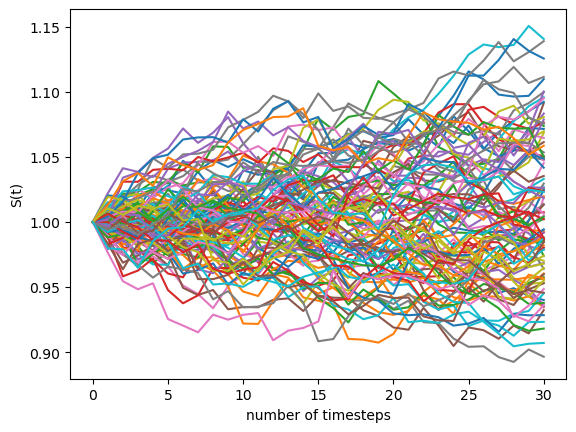

In [4]:
plt.plot(paths)
plt.xlabel('number of timesteps')
plt.ylabel('S(t)')

In [5]:
refdate = dt.datetime(2023,1,1)
issuer = 'DBK'
seclevel = 'COLLATERALIZED'
currency = 'EUR'
tpe = 'CALL' # Change to 'PUT' if you want to calculate the price of an european put option.
expiry = refdate + dt.timedelta(days=30)
strike = 1.
spec = EuropeanVanillaSpecification('Test_call', tpe, expiry, strike, 
                                                       issuer = issuer, sec_lvl = seclevel, curr='EUR',udl_id='ADS',
                                                       share_ratio = 1)

In [107]:
test1 =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=2,#3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=1, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=0.005,#5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.2,#0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [1.e-10]},threshold = 8.)#,loss ='expected_shortfall')#,transaction_cost = {'vanillaoption': [1.e-10]})

900/900 [==============================] - 15s 12ms/step - loss: 2.8852e-04


In [62]:
pricing_result_ES =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=2,#3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.5,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=0.005,#5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.2,#0.8, 
                                      seed=42,loss ='expected_shortfall')#,transaction_cost = {'vanillaoption': [1.e-10]})

Epoch 1/10
900/900 [==============================] - 12s 10ms/step - loss: 0.0326
Epoch 2/10
900/900 [==============================] - 9s 10ms/step - loss: 0.0282
Epoch 3/10
900/900 [==============================] - 9s 10ms/step - loss: 0.0276
Epoch 4/10
900/900 [==============================] - 10s 11ms/step - loss: 0.0275
Epoch 5/10
900/900 [==============================] - 13s 15ms/step - loss: 0.0274 - val_loss: 0.0272
Epoch 6/10
900/900 [==============================] - 9s 10ms/step - loss: 0.0272
Epoch 7/10
900/900 [==============================] - 8s 9ms/step - loss: 0.0271
Epoch 8/10
900/900 [==============================] - 9s 10ms/step - loss: 0.0272
Epoch 9/10
900/900 [==============================] - 12s 14ms/step - loss: 0.0271
Epoch 10/10
900/900 [==============================] - 12s 13ms/step - loss: 0.0269 - val_loss: 0.0274


In [64]:
pricing_result =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=2,#3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=50, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=0.005,#5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.2,#0.8, 
                                      seed=42)#,loss ='exponential_utility')#,transaction_cost = {'vanillaoption': [1.e-10]})

Epoch 1/50
900/900 [==============================] - 10s 8ms/step - loss: 1.1241e-04
Epoch 2/50
900/900 [==============================] - 9s 10ms/step - loss: 3.3881e-05
Epoch 3/50
900/900 [==============================] - 8s 9ms/step - loss: 2.4573e-05
Epoch 4/50
900/900 [==============================] - 8s 9ms/step - loss: 2.2921e-05
Epoch 5/50
900/900 [==============================] - 11s 12ms/step - loss: 2.3901e-05 - val_loss: 3.3731e-05
Epoch 6/50
900/900 [==============================] - 8s 9ms/step - loss: 2.3388e-05
Epoch 7/50
900/900 [==============================] - 8s 9ms/step - loss: 2.2927e-05
Epoch 8/50
900/900 [==============================] - 8s 9ms/step - loss: 2.2714e-05
Epoch 9/50
900/900 [==============================] - 7s 8ms/step - loss: 2.2269e-05
Epoch 10/50
900/900 [==============================] - 8s 9ms/step - loss: 2.0821e-05 - val_loss: 2.0594e-05
Epoch 11/50
900/900 [==============================] - 8s 8ms/step - loss: 2.1446e-05
Epoch 12/50
9

In [29]:
pricing_result_wtc =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=2,#3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=0.005,#5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.2,#0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [1.e-10]})#,loss ='exponential_utility')

Epoch 1/10
900/900 [==============================] - 9s 6ms/step - loss: 1.2664e-04
Epoch 2/10
900/900 [==============================] - 5s 6ms/step - loss: 3.4145e-05
Epoch 3/10
900/900 [==============================] - 5s 6ms/step - loss: 2.4311e-05
Epoch 4/10
900/900 [==============================] - 5s 6ms/step - loss: 2.3289e-05
Epoch 5/10
900/900 [==============================] - 7s 7ms/step - loss: 2.3605e-05 - val_loss: 2.7424e-05
Epoch 6/10
900/900 [==============================] - 6s 7ms/step - loss: 2.3150e-05
Epoch 7/10
900/900 [==============================] - 5s 5ms/step - loss: 2.2943e-05
Epoch 8/10
900/900 [==============================] - 5s 6ms/step - loss: 2.2688e-05
Epoch 9/10
900/900 [==============================] - 6s 6ms/step - loss: 2.1982e-05
Epoch 10/10
900/900 [==============================] - 5s 6ms/step - loss: 2.0976e-05 - val_loss: 2.1110e-05


In [36]:
pricing_result_wtc0001 =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=2,#3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=0.005,#5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.2,#0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [0.0001]})#loss ='exponential_utility',

Epoch 1/10
900/900 [==============================] - 7s 4ms/step - loss: 1.1513e-04
Epoch 2/10
900/900 [==============================] - 4s 4ms/step - loss: 3.2482e-05
Epoch 3/10
900/900 [==============================] - 4s 4ms/step - loss: 2.4644e-05
Epoch 4/10
900/900 [==============================] - 4s 4ms/step - loss: 2.3109e-05
Epoch 5/10
900/900 [==============================] - 7s 7ms/step - loss: 2.3602e-05 - val_loss: 3.7489e-05
Epoch 6/10
900/900 [==============================] - 7s 8ms/step - loss: 2.3569e-05
Epoch 7/10
900/900 [==============================] - 6s 6ms/step - loss: 2.2872e-05
Epoch 8/10
900/900 [==============================] - 5s 5ms/step - loss: 2.2623e-05
Epoch 9/10
900/900 [==============================] - 5s 6ms/step - loss: 2.2208e-05
Epoch 10/10
900/900 [==============================] - 5s 6ms/step - loss: 2.0925e-05 - val_loss: 2.2784e-05


In [37]:
pricing_result_wtc001 =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=2,#3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=0.005,#5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.2,#0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [0.001]})#loss ='exponential_utility',

Epoch 1/10
900/900 [==============================] - 12s 7ms/step - loss: 1.2208e-04
Epoch 2/10
900/900 [==============================] - 6s 7ms/step - loss: 3.7441e-05
Epoch 3/10
900/900 [==============================] - 5s 6ms/step - loss: 2.5054e-05
Epoch 4/10
900/900 [==============================] - 6s 6ms/step - loss: 2.4045e-05
Epoch 5/10
900/900 [==============================] - 9s 9ms/step - loss: 2.4459e-05 - val_loss: 3.2716e-05
Epoch 6/10
900/900 [==============================] - 6s 7ms/step - loss: 2.4219e-05
Epoch 7/10
900/900 [==============================] - 6s 7ms/step - loss: 2.3666e-05
Epoch 8/10
900/900 [==============================] - 6s 7ms/step - loss: 2.3473e-05
Epoch 9/10
900/900 [==============================] - 6s 7ms/step - loss: 2.2810e-05
Epoch 10/10
900/900 [==============================] - 6s 7ms/step - loss: 2.1766e-05 - val_loss: 2.3426e-05


In [38]:
pricing_result_wtc01 =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=2,#3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=0.005,#5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.2,#0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [0.01]})#loss ='exponential_utility',

Epoch 1/10
900/900 [==============================] - 10s 6ms/step - loss: 1.4762e-04
Epoch 2/10
900/900 [==============================] - 6s 6ms/step - loss: 4.5589e-05
Epoch 3/10
900/900 [==============================] - 6s 6ms/step - loss: 3.4390e-05
Epoch 4/10
900/900 [==============================] - 6s 7ms/step - loss: 3.4456e-05
Epoch 5/10
900/900 [==============================] - 8s 9ms/step - loss: 3.4520e-05 - val_loss: 5.4460e-05
Epoch 6/10
900/900 [==============================] - 6s 7ms/step - loss: 3.2993e-05
Epoch 7/10
900/900 [==============================] - 6s 7ms/step - loss: 3.2695e-05
Epoch 8/10
900/900 [==============================] - 6s 7ms/step - loss: 3.3543e-05
Epoch 9/10
900/900 [==============================] - 6s 7ms/step - loss: 3.1856e-05
Epoch 10/10
900/900 [==============================] - 6s 7ms/step - loss: 3.0562e-05 - val_loss: 2.8557e-05


In [7]:
pnl = pricing_result.hedge_model.compute_pnl(pricing_result.paths, pricing_result.payoff)
inputs = pricing_result.hedge_model._create_inputs(pricing_result.paths)
loss = pricing_result.hedge_model.evaluate(inputs, pricing_result.payoff)

test = {'mean': pnl.mean(), 'var': pnl.var(), 
            'loss': loss,
            '1%':np.percentile(pnl,1), '99%': np.percentile(pnl,99),
            '5%':np.percentile(pnl,5), '95%': np.percentile(pnl,95)}

(<tf.Tensor 'IteratorGetNext:0' shape=(32, 366) dtype=float32>,)
3125/3125 [==============================] - 103s 29ms/step
(<tf.Tensor 'IteratorGetNext:0' shape=(32, 366) dtype=float32>,)
3125/3125 [==============================] - 122s 35ms/step - loss: 1.7904e-09


In [39]:
pnl = pricing_result.hedge_model.compute_pnl(pricing_result.paths, pricing_result.payoff)
pnl_wtc = pricing_result_wtc.hedge_model.compute_pnl(pricing_result_wtc.paths, pricing_result_wtc.payoff)
pnl_wtc0001 = pricing_result_wtc0001.hedge_model.compute_pnl(pricing_result_wtc0001.paths, pricing_result_wtc0001.payoff)
pnl_wtc001 = pricing_result_wtc001.hedge_model.compute_pnl(pricing_result_wtc001.paths, pricing_result_wtc001.payoff)
pnl_wtc01 = pricing_result_wtc01.hedge_model.compute_pnl(pricing_result_wtc01.paths, pricing_result_wtc01.payoff)

3125/3125 [==============================] - 8s 2ms/step


In [97]:
pnl_test1 = test1.hedge_model.compute_pnl(test1.paths, test1.payoff)

3125/3125 [==============================] - 9s 3ms/step


Text(0.5, 0, 'PnL')

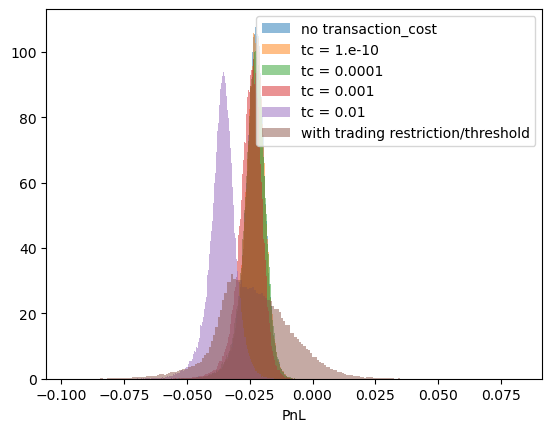

In [99]:
plt.hist(pnl, bins=200, label='no transaction_cost', density=True, alpha=0.5)
plt.hist(pnl_wtc, bins=200, label='tc = 1.e-10', density=True, alpha=0.5)
plt.hist(pnl_wtc0001, bins=200, label='tc = 0.0001', density=True, alpha=0.5)
plt.hist(pnl_wtc001, bins=200, label='tc = 0.001', density=True, alpha=0.5)
plt.hist(pnl_wtc01, bins=200, label='tc = 0.01', density=True, alpha=0.5)
plt.hist(pnl_test1, bins=200, label='with trading restriction/threshold', density=True, alpha=0.5)
plt.legend()
plt.xlabel('PnL')

In [65]:
t = -2
delta = pricing_result.hedge_model.compute_delta(pricing_result.paths, t).reshape((-1,))


3125/3125 [==============================] - 2s 747us/step


In [41]:
t = -2
delta_wtc = pricing_result_wtc.hedge_model.compute_delta(pricing_result_wtc.paths, t).reshape((-1,))
delta_wtc0001 = pricing_result_wtc0001.hedge_model.compute_delta(pricing_result_wtc0001.paths, t).reshape((-1,))
delta_wtc001 = pricing_result_wtc001.hedge_model.compute_delta(pricing_result_wtc001.paths, t).reshape((-1,))
delta_wtc01 = pricing_result_wtc01.hedge_model.compute_delta(pricing_result_wtc01.paths, t).reshape((-1,))

3125/3125 [==============================] - 4s 1ms/step


In [56]:
t = -2
delta_ES = pricing_result_ES.hedge_model.compute_delta(pricing_result_ES.paths, t).reshape((-1,))

3125/3125 [==============================] - 2s 738us/step


In [66]:
v = pricing_result.paths
v = v['vanillaoption']

v_wtc = pricing_result_wtc.paths
v_wtc = v_wtc['vanillaoption']

v_wtc0001 = pricing_result_wtc0001.paths
v_wtc0001 = v_wtc0001['vanillaoption']

v_wtc001 = pricing_result_wtc001.paths
v_wtc001 = v_wtc001['vanillaoption']

v_wtc01 = pricing_result_wtc01.paths
v_wtc01 = v_wtc01['vanillaoption']

v_ES = pricing_result_ES.paths
v_ES = v_ES['vanillaoption']

0.03688702080172552


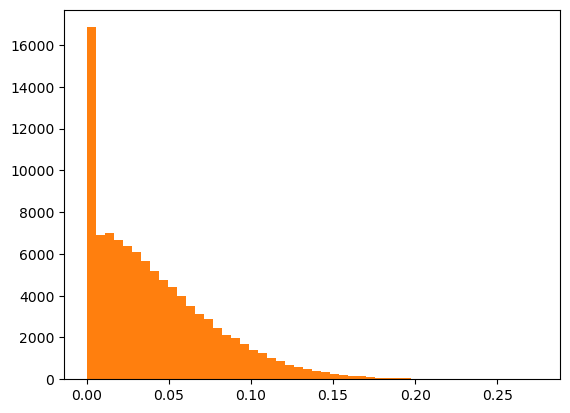

In [22]:
plt.hist(np.max(v-1.,0), bins=50)
plt.hist(np.max(v_wtc-1.,0), bins=50)
payoff = np.max(v-1.,0)
print(np.std(np.max(v-1.,0)))

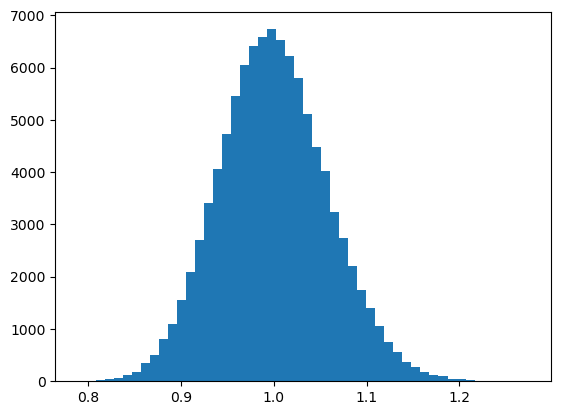

In [23]:
plt.hist(v[-1,:],bins = 50);

In [24]:
import scipy
t = -2
drift = 0.0
volatility=0.2
S = np.linspace(0.8,1.2,30)
d1 = (np.log(S/1.) + (drift + volatility*volatility*0.5)*(model._delta_t))/(volatility*np.sqrt(model._delta_t))

delta_BS = scipy.stats.norm.cdf(d1)

print(delta_BS)


[8.96544719e-98 1.08736396e-83 6.23676000e-71 1.95203984e-59
 3.81626547e-49 5.29529184e-40 5.88605999e-32 5.88077650e-25
 5.89485015e-19 6.59024316e-14 9.11071124e-10 1.72686686e-06
 5.00175177e-04 2.51022595e-02 2.59580458e-01 7.42418551e-01
 9.73113015e-01 9.99286994e-01 9.99995360e-01 9.99999992e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


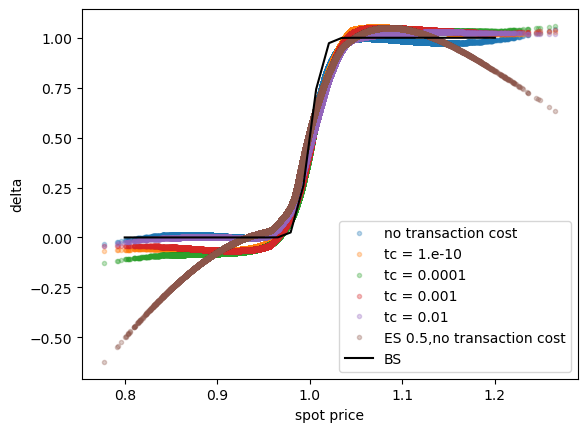

In [67]:

plt.plot(v[t,:], delta,'.', label='no transaction cost', alpha=0.3)
plt.plot(v_wtc[t,:], delta_wtc,'.', label='tc = 1.e-10', alpha=0.3)
plt.plot(v_wtc0001[t,:], delta_wtc0001,'.', label='tc = 0.0001', alpha=0.3)
plt.plot(v_wtc001[t,:], delta_wtc001,'.', label='tc = 0.001', alpha=0.3)
plt.plot(v_wtc01[t,:], delta_wtc01,'.', label='tc = 0.01', alpha=0.3)
plt.plot(v_ES[t,:], delta_ES,'.', label='ES 0.5,no transaction cost', alpha=0.3)
plt.plot(S,delta_BS,label='BS',color='black')
plt.xlabel('spot price')
plt.ylabel('delta')
plt.legend()